# Ray Path Visualization

This notebook demonstrates how to extract and visualize seismic ray paths through 1D Earth models using the `seisray` package.

## Learning Objectives
- Extract ray paths for different seismic phases
- Visualize ray paths on circular Earth cross-sections
- Analyze ray path properties (turning points, pierce points)
- Compare ray paths between different phases and models

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import sys
import os

# Add the parent directory to the path to import seisray
sys.path.append(os.path.dirname(os.getcwd()))

from sensray import RayPathTracer, EarthPlotter

print("Successfully imported sensray package!")

Successfully imported sensray package!


## 1. Basic Ray Path Extraction

Let's start by extracting ray paths for P and S waves at a specific distance.

In [2]:
# Set up parameters
source_depth = 10  # km
distance = 60      # degrees

# Create ray path tracer
tracer = RayPathTracer('iasp91')

# Extract P-wave ray path
p_rays, p_info = tracer.get_ray_paths(source_depth=source_depth, distance_deg=distance, phases=['P'])
print(f"Found {len(p_rays)} P-wave ray path(s)")

# Extract S-wave ray path
s_rays, s_info = tracer.get_ray_paths(source_depth=source_depth, distance_deg=distance, phases=['S'])
print(f"Found {len(s_rays)} S-wave ray path(s)")

# Analyze the P-wave ray path
if p_rays:
    p_ray = p_rays[0]
    print(f"\nP-wave ray path details:")
    print(f"  Number of points: {len(p_ray.path['dist'])}")
    print(f"  Maximum depth: {np.max(p_ray.path['depth']):.1f} km")
    print(f"  Travel time: {p_ray.time:.1f} s")
    print(f"  Phase name: {p_ray.name}")

Found 1 P-wave ray path(s)
Found 1 S-wave ray path(s)

P-wave ray path details:
  Number of points: 286
  Maximum depth: 1548.0 km
  Travel time: 606.7 s
  Phase name: P


## 2. Visualizing Ray Paths on Earth Cross-Section

Now let's create a circular Earth cross-section and plot the ray paths.

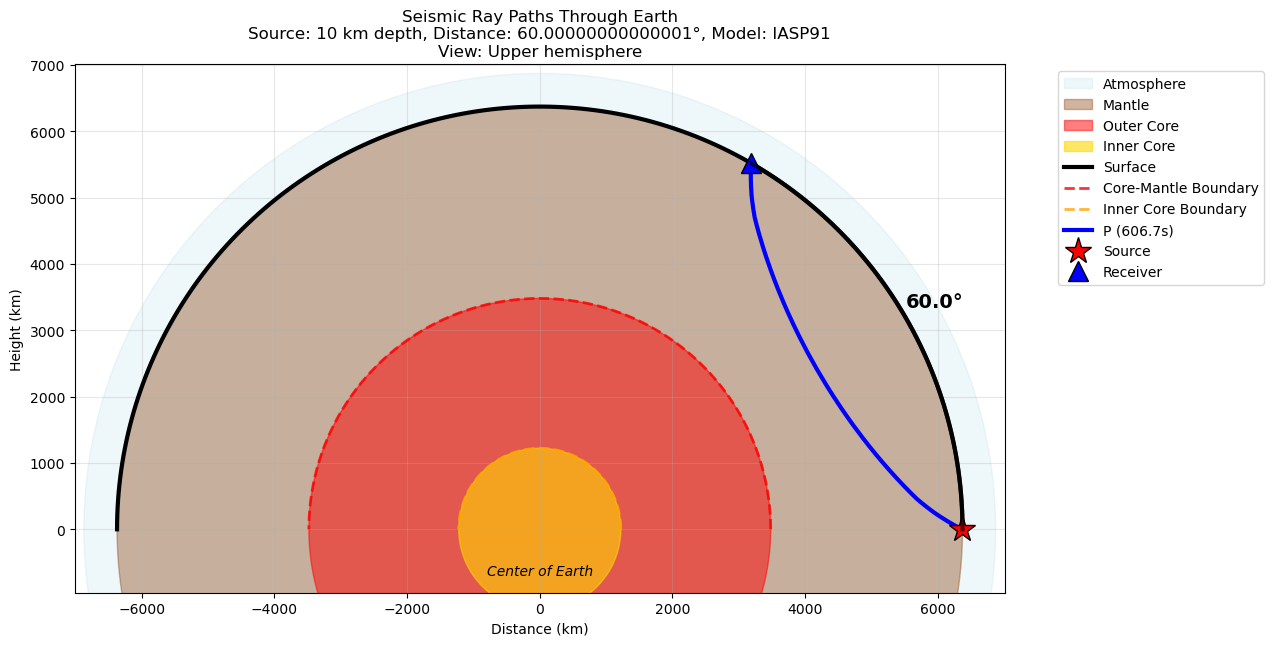

In [3]:
# Use seisray's EarthPlotter to create professional circular Earth visualization
plotter = EarthPlotter()

# Extract ray coordinates using seisray's built-in method
if p_rays:
    ray_coordinates = tracer.extract_ray_coordinates(p_rays)

    # Get the actual distance from the ray
    actual_distance = p_rays[0].distance

    # Create the circular Earth plot using seisray's plotting method
    fig = plotter.plot_circular_earth(
        ray_coordinates=ray_coordinates,
        source_depth=source_depth,
        distance_deg=actual_distance,
        fig_size=(12, 12)
    )

    plt.show()
else:
    print("No P-wave ray paths found for this distance")

 ## 3. Comparing P and S Wave Ray Paths

Let's plot both P and S wave ray paths on the same diagram.

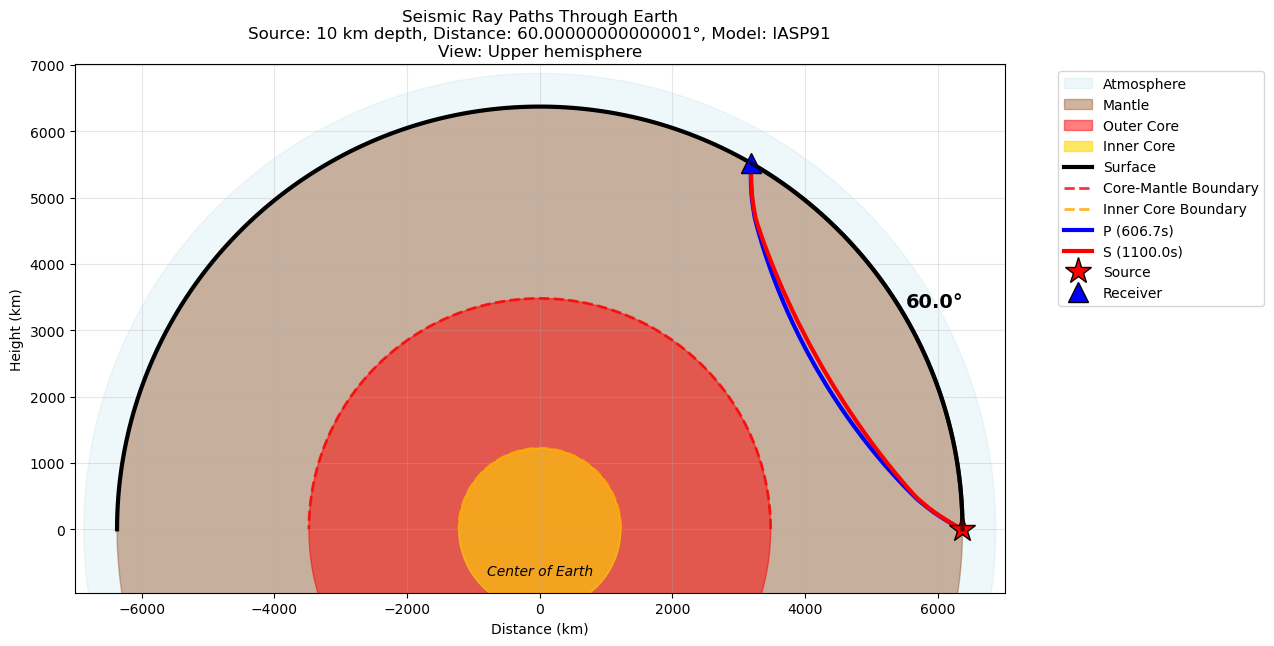

In [4]:
# Compare P and S wave ray paths using seisray's plotting functionality
if p_rays or s_rays:
    # Combine P and S rays
    all_rays = []
    if p_rays:
        all_rays.extend(p_rays)
    if s_rays:
        all_rays.extend(s_rays)

    # Extract coordinates for all rays
    ray_coordinates = tracer.extract_ray_coordinates(all_rays)

    # Get actual distance
    if p_rays:
        actual_distance = p_rays[0].distance
    elif s_rays:
        actual_distance = s_rays[0].distance
    else:
        actual_distance = distance

    # Create the plot
    fig = plotter.plot_circular_earth(
        ray_coordinates=ray_coordinates,
        source_depth=source_depth,
        distance_deg=actual_distance,
        fig_size=(12, 12)
    )

    plt.show()
else:
    print("No ray paths found for this distance")

## 4. Ray Paths at Different Distances

Let's visualize how P-wave ray paths change with epicentral distance.

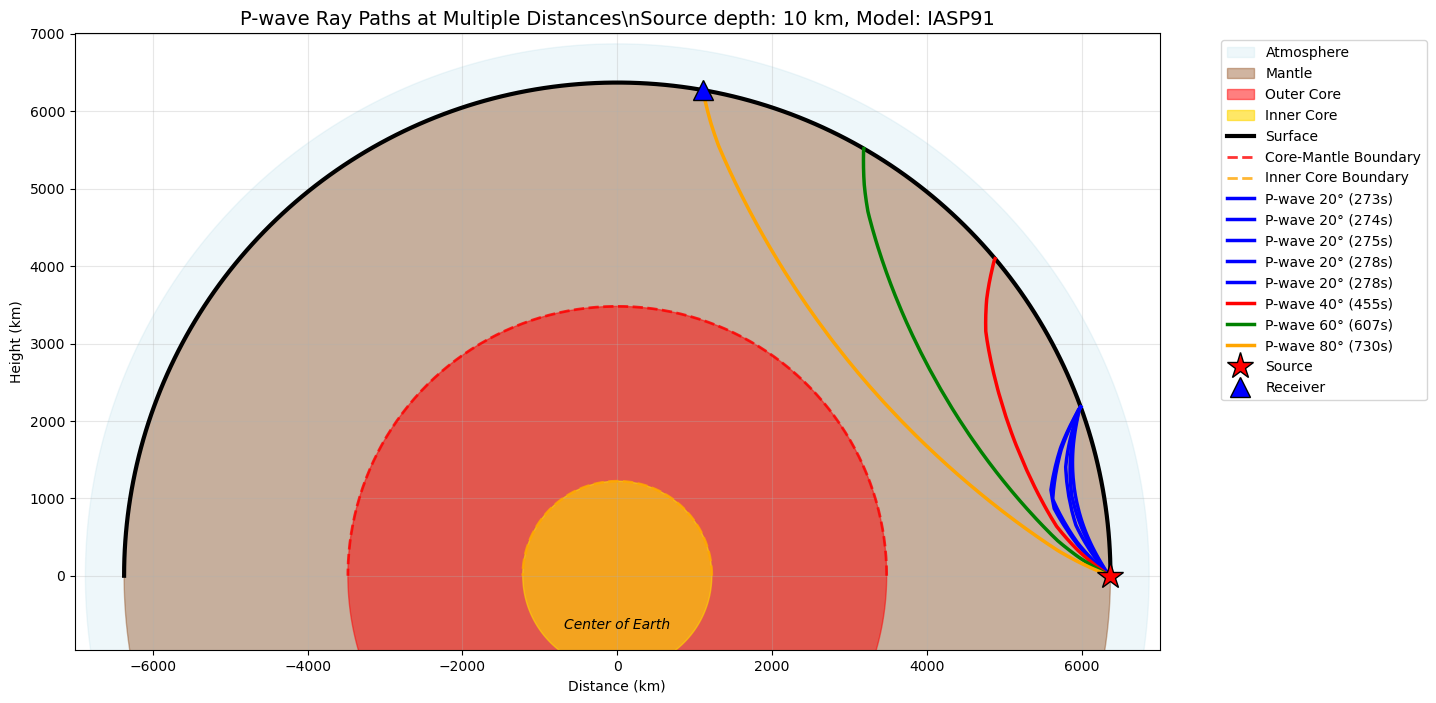

In [5]:
# Plot ray paths for multiple distances using seisray
distances = [20, 40, 60, 80]
colors = ['blue', 'red', 'green', 'orange']

# For multiple distances, we'll create a manual plot but use seisray's coordinate extraction
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Create Earth plotter to get structure parameters
plotter = EarthPlotter()
earth_radius = plotter.earth_structure['earth_radius']
cmb_radius = plotter.earth_structure['cmb_radius']
icb_radius = plotter.earth_structure['icb_radius']

# Create angular arrays for boundaries
theta = np.linspace(0, np.pi, 180)  # Semicircle
theta_full = np.linspace(0, 2*np.pi, 360)  # Full circle for filling

# Use plotter's internal methods to set up Earth structure
plotter._fill_earth_layers(ax, theta_full, earth_radius, cmb_radius, icb_radius, show_atmosphere=True)
plotter._plot_earth_boundaries(ax, theta, earth_radius, cmb_radius, icb_radius)

# Plot ray paths for different distances
for i, dist in enumerate(distances):
    rays, _ = tracer.get_ray_paths(source_depth=source_depth, distance_deg=dist, phases=['P'])
    if rays:
        # Extract coordinates using seisray's method
        ray_coords = tracer.extract_ray_coordinates(rays)

        # Plot each ray path
        for phase, coords in ray_coords.items():
            color = colors[i % len(colors)]
            ax.plot(coords['x_cartesian'], coords['y_cartesian'],
                   color=color, linewidth=2.5,
                   label=f'P-wave {dist}° ({coords["total_time"]:.0f}s)')

# Mark source and receivers using plotter's method
plotter._mark_source_receiver(ax, source_depth, distances[-1], earth_radius)

# Format the plot
plotter._format_earth_plot(ax, source_depth, "Multiple distances", earth_radius)

# Override title for multiple distances
ax.set_title(f'P-wave Ray Paths at Multiple Distances\\n'
            f'Source depth: {source_depth} km, Model: {plotter.model_name.upper()}',
            fontsize=14)

plt.show()

## 5. Analyzing Ray Path Properties

Let's extract and analyze specific properties of the ray paths.

In [6]:
# Analyze ray paths at different distances
distances = np.linspace(10, 90, 17)
max_depths = []
travel_times = []
turning_depths = []

print(f"{'Distance (°)':<12} {'Travel Time (s)':<15} {'Max Depth (km)':<15} {'Turning Depth (km)':<15}")
print("-" * 70)

for distance in distances:
    rays, _ = tracer.get_ray_paths(source_depth=source_depth, distance_deg=distance, phases=['P'])

    if rays:
        ray = rays[0]
        max_depth = np.max(ray.path['depth'])
        travel_time = ray.time

        # Find turning point (deepest point)
        turning_depth = max_depth

        max_depths.append(max_depth)
        travel_times.append(travel_time)
        turning_depths.append(turning_depth)

        print(f"{distance:<12.1f} {travel_time:<15.1f} {max_depth:<15.1f} {turning_depth:<15.1f}")
    else:
        max_depths.append(np.nan)
        travel_times.append(np.nan)
        turning_depths.append(np.nan)
        print(f"{distance:<12.1f} {'No ray found':<15} {'N/A':<15} {'N/A':<15}")

Distance (°) Travel Time (s) Max Depth (km)  Turning Depth (km)
----------------------------------------------------------------------
10.0         143.7           58.1            58.1           
15.0         212.0           175.9           175.9          
20.0         272.7           448.2           448.2          
25.0         323.9           696.3           696.3          
30.0         368.7           764.4           764.4          
35.0         412.4           842.9           842.9          
40.0         454.7           954.1           954.1          
45.0         495.4           1083.6          1083.6         
50.0         534.3           1227.8          1227.8         
55.0         571.4           1382.9          1382.9         
60.0         606.7           1548.0          1548.0         
65.0         640.1           1720.8          1720.8         
70.0         671.8           1903.9          1903.9         
75.0         701.6           2098.1          2098.1         
80.0       

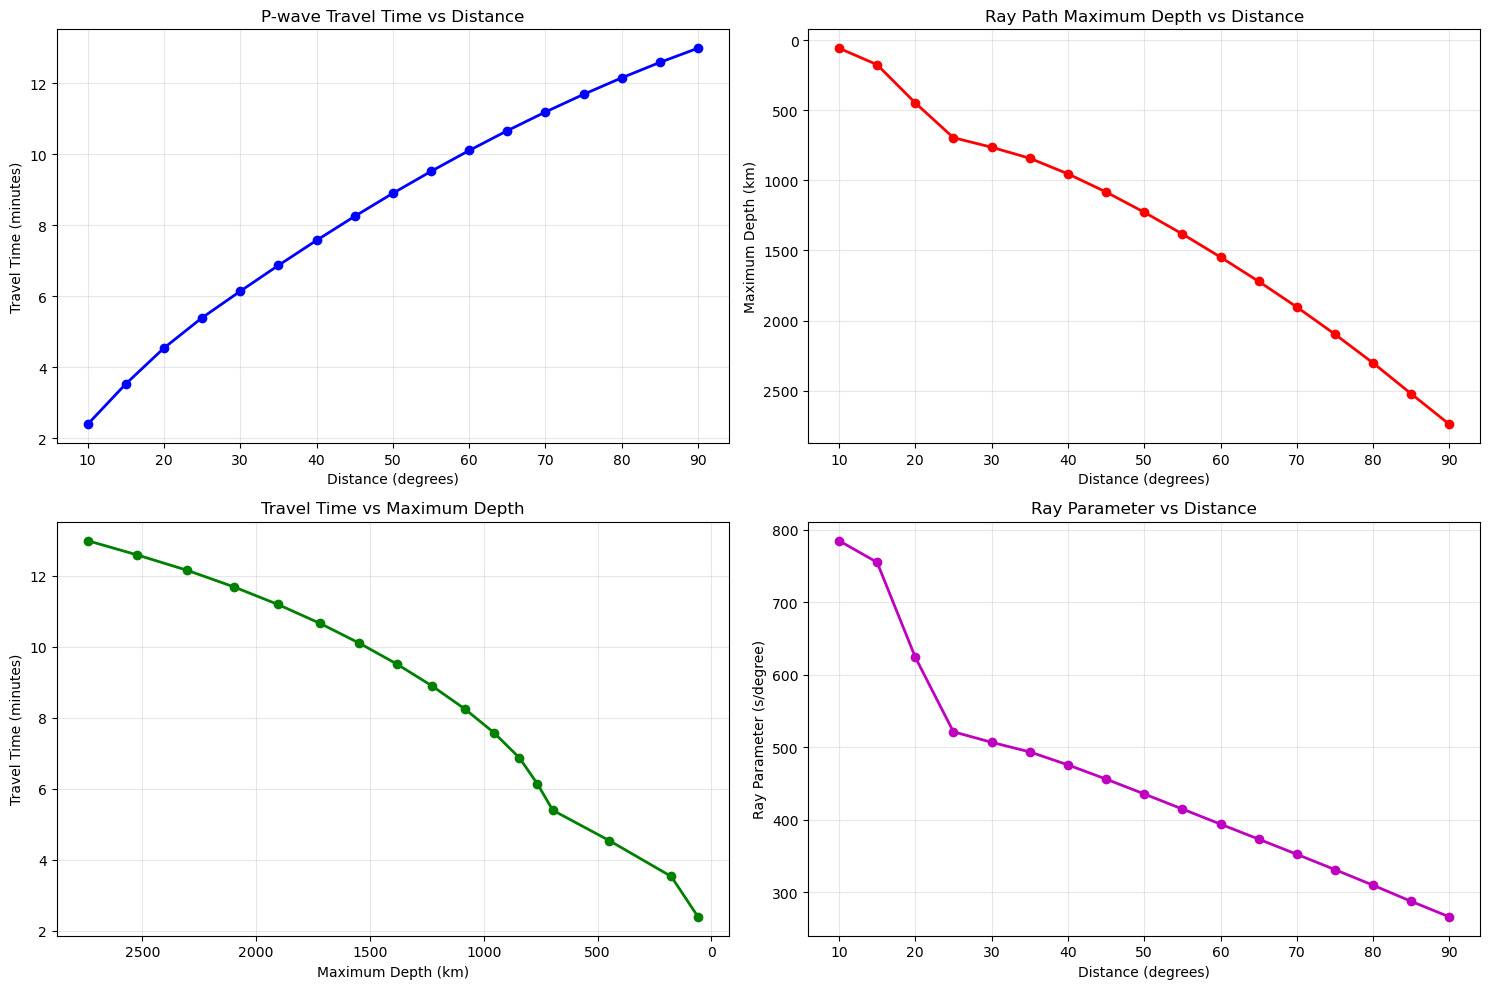

In [7]:
# Plot ray path properties
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Travel time vs distance
axes[0, 0].plot(distances, np.array(travel_times)/60, 'bo-', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Distance (degrees)')
axes[0, 0].set_ylabel('Travel Time (minutes)')
axes[0, 0].set_title('P-wave Travel Time vs Distance')
axes[0, 0].grid(True, alpha=0.3)

# Maximum depth vs distance
axes[0, 1].plot(distances, max_depths, 'ro-', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Distance (degrees)')
axes[0, 1].set_ylabel('Maximum Depth (km)')
axes[0, 1].set_title('Ray Path Maximum Depth vs Distance')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].invert_yaxis()

# Travel time vs max depth
axes[1, 0].plot(max_depths, np.array(travel_times)/60, 'go-', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Maximum Depth (km)')
axes[1, 0].set_ylabel('Travel Time (minutes)')
axes[1, 0].set_title('Travel Time vs Maximum Depth')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].invert_xaxis()

# Ray parameter analysis
ray_parameters = []
for distance in distances:
    rays, _ = tracer.get_ray_paths(source_depth=source_depth, distance_deg=distance, phases=['P'])
    if rays:
        ray_parameters.append(rays[0].ray_param)
    else:
        ray_parameters.append(np.nan)

axes[1, 1].plot(distances, ray_parameters, 'mo-', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Distance (degrees)')
axes[1, 1].set_ylabel('Ray Parameter (s/degree)')
axes[1, 1].set_title('Ray Parameter vs Distance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Multiple Phases Comparison

Let's look at different seismic phases and their ray paths.

Ray paths for distance = 40°:
----------------------------------------
P    Travel time: 454.7 s, Max depth: 954.1 km
S    Travel time: 821.1 s, Max depth: 938.0 km
PP   Travel time: 546.8 s, Max depth: 447.7 km
SS   Travel time: 999.3 s, Max depth: 450.6 km


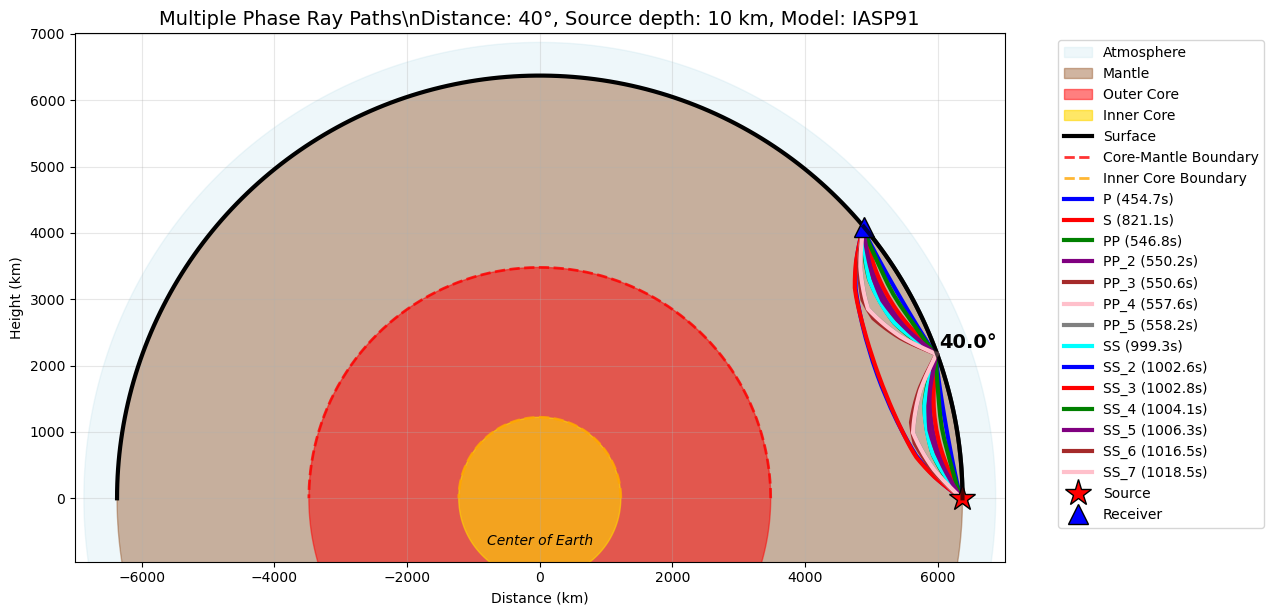

In [8]:
# Multiple phases comparison using seisray plotting
distance = 40
phases = ['P', 'S', 'PP', 'SS']

print(f"Ray paths for distance = {distance}°:")
print("-" * 40)

# Get all rays for the specified phases
all_rays = []
for phase in phases:
    rays, _ = tracer.get_ray_paths(source_depth=source_depth, distance_deg=distance, phases=[phase])
    if rays:
        all_rays.extend(rays)
        ray = rays[0]
        print(f"{phase:<4} Travel time: {ray.time:.1f} s, Max depth: {np.max(ray.path['depth']):.1f} km")
    else:
        print(f"{phase:<4} No ray found")

# Plot using seisray if we have any rays
if all_rays:
    # Extract coordinates
    ray_coordinates = tracer.extract_ray_coordinates(all_rays)

    # Create the plot
    fig = plotter.plot_circular_earth(
        ray_coordinates=ray_coordinates,
        source_depth=source_depth,
        distance_deg=distance,
        fig_size=(12, 10)
    )

    # Update title to reflect multiple phases
    ax = fig.get_axes()[0]
    ax.set_title(f'Multiple Phase Ray Paths\\n'
                f'Distance: {distance}°, Source depth: {source_depth} km, '
                f'Model: {plotter.model_name.upper()}', fontsize=14)

    plt.show()
else:
    print("No ray paths found for any of the specified phases")